variational autoencoder 1

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib as plt

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, 
                               transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, 
                              transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw




Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw




Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
class CVAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim, c_dim):
        super(CVAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim + c_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim + c_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
    
    def encoder(self, x, c):
        concat_input = torch.cat([x, c], 1)
        h = F.relu(self.fc1(concat_input))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add(mu) # return z sample
    
    def decoder(self, z, c):
        concat_input = torch.cat([z, c], 1)
        h = F.relu(self.fc4(concat_input))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h))
    
    def forward(self, x, c):
        mu, log_var = self.encoder(x.view(-1, 784), c)
        z = self.sampling(mu, log_var)
        return self.decoder(z, c), mu, log_var

# build model
cond_dim = train_loader.dataset.train_labels.unique().size(0)
cvae = CVAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=2, c_dim=cond_dim)
if torch.cuda.is_available():
    cvae.cuda()

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [4]:
cvae

CVAE(
  (fc1): Linear(in_features=794, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=12, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [5]:
optimizer = optim.Adam(cvae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

# one-hot encoding
def one_hot(labels, class_size): 
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return Variable(targets)

In [6]:
def train(epoch):
    cvae.train()
    train_loss = 0
    for batch_idx, (data, cond) in enumerate(train_loader):
        data, cond = data.cuda(), one_hot(cond, cond_dim).cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = cvae(data, cond)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [7]:
def test():
    cvae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, cond in test_loader:
            data, cond = data.cuda(), one_hot(cond, cond_dim).cuda()
            recon, mu, log_var = cvae(data, cond)
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [8]:
# train
for epoch in range(1,51):
    train(epoch)
    test()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 542.695078
Train Epoch: 1 [10000/60000 (17%)]	Loss: 171.994824
Train Epoch: 1 [20000/60000 (33%)]	Loss: 157.380713
Train Epoch: 1 [30000/60000 (50%)]	Loss: 146.871904
Train Epoch: 1 [40000/60000 (67%)]	Loss: 149.022266
Train Epoch: 1 [50000/60000 (83%)]	Loss: 149.949775
====> Epoch: 1 Average loss: 162.8021
====> Test set loss: 141.3836
Train Epoch: 2 [0/60000 (0%)]	Loss: 140.775332
Train Epoch: 2 [10000/60000 (17%)]	Loss: 142.860146
Train Epoch: 2 [20000/60000 (33%)]	Loss: 132.468760
Train Epoch: 2 [30000/60000 (50%)]	Loss: 137.475371
Train Epoch: 2 [40000/60000 (67%)]	Loss: 135.811592
Train Epoch: 2 [50000/60000 (83%)]	Loss: 134.814424
====> Epoch: 2 Average loss: 138.7178
====> Test set loss: 136.8397
Train Epoch: 3 [0/60000 (0%)]	Loss: 131.887070
Train Epoch: 3 [10000/60000 (17%)]	Loss: 142.475850
Train Epoch: 3 [20000/60000 (33%)]	Loss: 132.622100
Train Epoch: 3 [30000/60000 (50%)]	Loss: 134.433232
Train Epoch: 3 [40000/60000 (67%)]	Loss: 131.72

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
with torch.no_grad():
    z = torch.randn(10, 2).cuda()
    c = torch.eye(10).cuda()

    sample = cvae.decoder(z, c)
    
    save_image(sample.view(10, 1, 28, 28), '/content/gdrive' + '.png')
    # !cp sample '/content/gdrive'

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


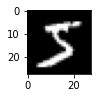

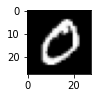

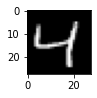

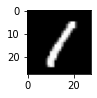

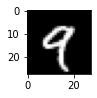

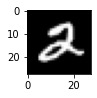

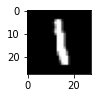

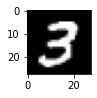

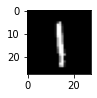

In [21]:
# loading handwriting image from training set
from keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()


import matplotlib

from matplotlib import pyplot
for i in range(9):	
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(train_X[i], cmap=pyplot.get_cmap('gray'))
  pyplot.show()

# https://www.askpython.com/python/examples/load-and-plot-mnist-dataset-in-python

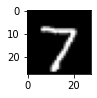

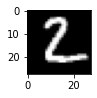

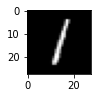

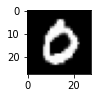

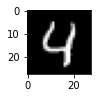

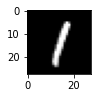

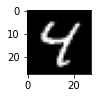

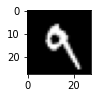

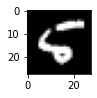

In [22]:
# loading handwriting image from test set
for i in range(9):	
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(test_X[i], cmap=pyplot.get_cmap('gray'))
  pyplot.show()
